WARNING  py.warnings: /home/hanyu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


WARNING  brian2.devices.cpp_standalone.device.openmp: OpenMP code is not yet well tested, and may be inaccurate.


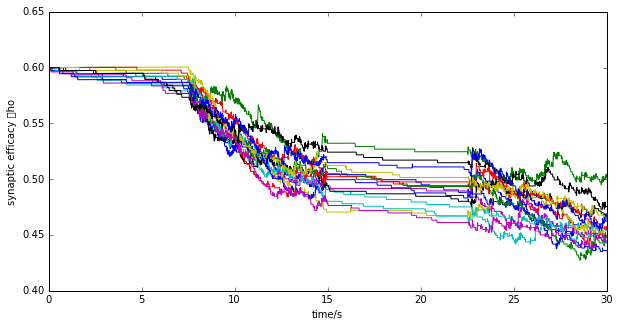

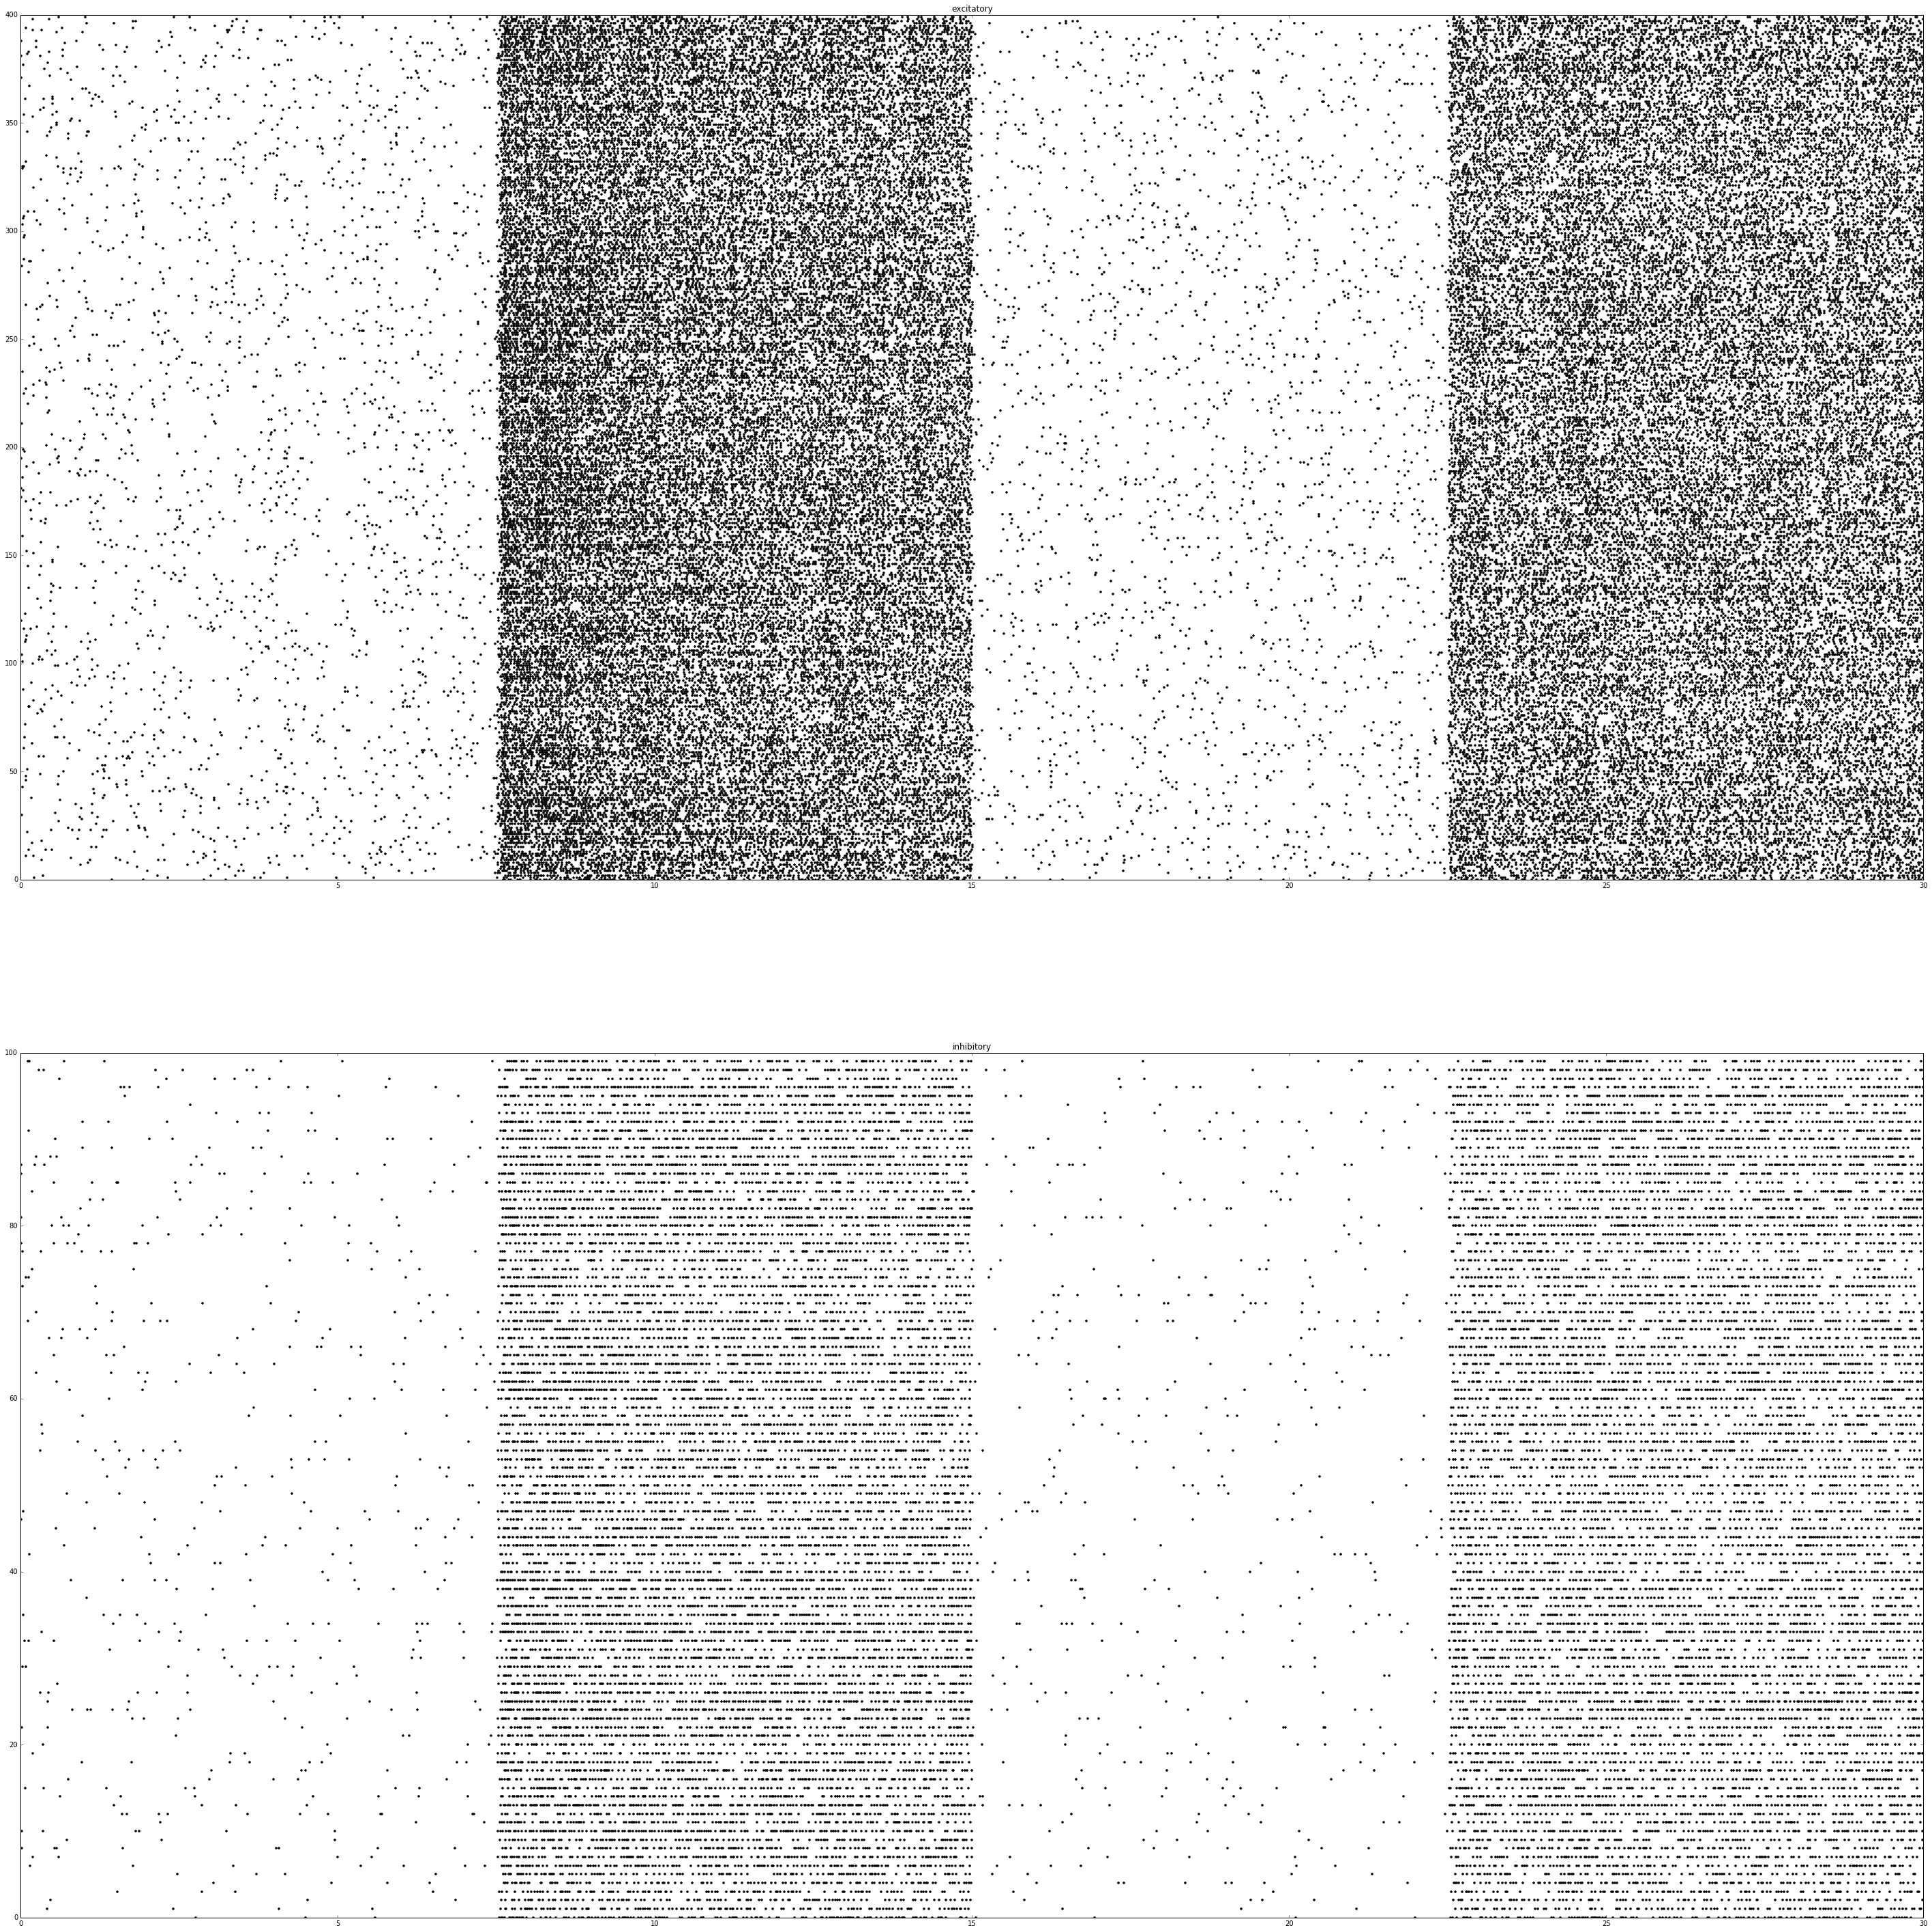

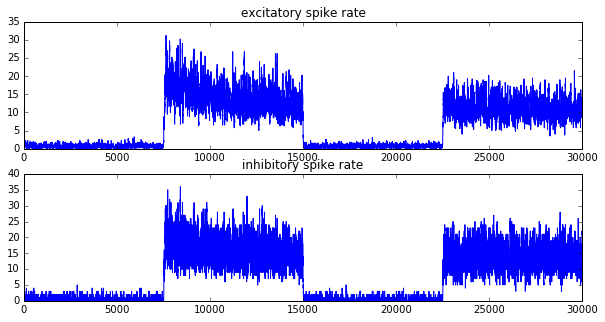

<spikemonitor.i: array([371, 388, 195, ...,  16, 204, 377], dtype=int32)>
(15,)


In [1]:

# coding: utf-8

# In[ ]:

from brian2 import *
import csv
import pylab

#get_ipython().magic(u'matplotlib inline')
%matplotlib inline

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(1, figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
def build_input(amplitude, cumulative_share, length, N):
    I = np.zeros((length, N), dtype=float64)
    splits = np.multiply(cumulative_share, length)
    #print splits
    #I[0:splits[0]] = 
    for i in arange(len(amplitude)):
        I[splits[i]:splits[i+1],:] = amplitude[i]
    return I
    
class Brian_Simulator:
    def __init__(self, simulation_length, N_E, N_I,sample, I_ext_E, I_ext_I, params):
        self.simulation_length = simulation_length
        self.N_E = N_E
        self.N_I = N_I
        self.I_ext_E = I_ext_E
        self.I_ext_I = I_ext_I
        self.sample = sample
        self.params = params

    def run(self):
        set_device('cpp_standalone')
        prefs.devices.cpp_standalone.openmp_threads = 8
        start_scope()
        #control parameters
        debug = True
        #simulation_length = 10000
        observe_window = 100
        #N = 1000
        E_record_id = range(self.sample)
        I_record_id = range(self.sample)

        F = 1000*Hz

        #Variables used in brian code
        cpre_0 = self.params['cpre_0']
        cpost_0 = self.params['cpost_0']
        rho_0 = self.params['rho_0']
        c = self.params['c']
        dummy =self.params['dummy']
        Ipre =self.params['Ipre']
        Ipost = self.params['Ipost']
        w0 = self.params['w0']
        w_EE = self.params['w_EE']
        w_IE = self.params['w_IE']
        w_EI = self.params['w_EI']
        w_II = self.params['w_II']
        #LIF specific constants
        tau_lif = self.params['tau_lif']*ms
        V_init = self.params['V_init']
        V_rest = self.params['V_rest']
        V_reset = self.params['V_reset']
        V_threshold = self.params['V_threshold']
        CM = self.params['CM']
        RM = self.params['RM']
        sigma = self.params['sigma']
        refrac = self.params['refrac']
        #Synapse model specific constants
        rho_init = self.params['rho_init']
        ca_initial = self.params['ca_initial']
        ca_delay = self.params['ca_delay']
        Cpre = self.params['Cpre']
        Cpost = self.params['Cpost']
        tau_ca = self.params['tau_ca']
        theta_D = self.params['theta_D']
        theta_P = self.params['theta_P']
        gamma_D = self.params['gamma_D']
        gamma_P = self.params['gamma_P']
        taurho = self.params['taurho']*ms
        taurho_fast = self.params['taurho_fast']*ms # dummy
        taupre = self.params['taupre']*ms
        taupost =self.params['taupost']*ms
        tau_ca = self.params['tau_ca']*ms
        rho_star = self.params['rho_star']
        D = self.params['D']
        
        stim_E = TimedArray(self.I_ext_E, dt=1*ms)
        stim_I = TimedArray(self.I_ext_I, dt=1*ms)
        lif_eqs_E = '''
        dv/dt = (- (v+70) + stim_E(t,i)) / tau_lif + sigma*xi*tau_lif**-0.5 : 1
        '''
        lif_eqs_I = '''
        dv/dt = (- (v+70) + stim_I(t,i)) / tau_lif + sigma*xi*tau_lif**-0.5 : 1
        '''
        #P = PoissonGroup(N, rates=F)
        # = NeuronGroup(2, eqs, threshold='v>vt', reset='v = vr')
        #S = Synapses(G, G, pre='v+=1*mV', connect='i==0 and j==1')


        G_E = NeuronGroup(self.N_E, lif_eqs_E, threshold='v>V_threshold', reset='v = V_reset')
        G_E.v = V_init

        G_I = NeuronGroup(self.N_I, lif_eqs_I, threshold='v>V_threshold', reset='v = V_reset')
        G_I.v = V_init




        # plastic models
        synaptic_model_plastic = '''
                    w : 1 
                    dcpre/dt = -cpre / taupre : 1
                    dcpost/dt = -cpost / taupost : 1
                    c = cpre + cpost : 1
                    dummy = (c>theta_D) : 1
                    drho/dt = (-rho*(1-rho)*(0.5-rho) + gamma_P*(1-rho)*(c>theta_P) - gamma_D*rho*(c>theta_D)) / taurho : 1
                    '''
        
        pre_model_E_plastic = '''
                    v_post += rho
                    cpre += Cpre              
                    '''
        post_model_E_plastic = '''
                    cpost += Cpost
                    
                    '''
        
        # static models
        synaptic_model_static = '''
                    rho : 1
                    ''' 
        pre_model_E_static = '''
                    v_post += rho
                    '''
        
        pre_model_I_static = '''
                    v_post += -rho                 
                    '''
        
        # no post_model_I




        S_EE = Synapses(G_E, G_E, model = synaptic_model_plastic, pre = pre_model_E_plastic, post = post_model_E_plastic)
        S_EI = Synapses(G_E, G_I, model = synaptic_model_static, pre = pre_model_E_static, post = None)
        S_IE = Synapses(G_I, G_E, model = synaptic_model_static, pre = pre_model_I_static, post = None)
        S_II = Synapses(G_I, G_I, model = synaptic_model_static, pre = pre_model_I_static, post = None)
        
        
        S_EE.connect('i!=j', p=0.1)
        S_EI.connect(True, p=0.1)
        S_IE.connect(True, p=0.1)
        S_II.connect(True, p=0.1)

        #tmp = ((np.arange(len(S))+1) * 4).tolist()
        #S.delay = tmp*ms
        #S.delay = [4, 40, 400, 4000]*ms
        
        S_EE.cpre = cpre_0
        S_EE.cpost= cpost_0
        S_EE.rho = rho_0
        
        
        S_EI.rho = rho_0
        
        S_IE.rho = rho_0
        
        S_II.rho = rho_0
        
       
        
        #G_E.I_ext = self.I_ext_E
        #G_E.I_ext = [25] * self.N_E
        #G_E.I_ext[0] = 50

        #statemon = StateMonitor(G, 'v', record = True)
        #spikemon = SpikeMonitor(G)

        # Unrecorded simulation
        #statemon_S = StateMonitor(S, ['rho'], record = [0,1], dt=0.1*ms)
        statemon_S = StateMonitor(S_EE, ['rho'], record = E_record_id, dt=1*ms)
        spikemon_G_E = SpikeMonitor(G_E)
        spikemon_G_I = SpikeMonitor(G_I)
        popratemon_G_E = PopulationRateMonitor(G_E)
        popratemon_G_I = PopulationRateMonitor(G_I)
        run((self.simulation_length-observe_window)*ms, report='stdout', report_period=1*second)
        # Recorded simulation
        run(observe_window*ms, report='stdout', report_period=1*second)

        device.build(directory='output', compile=True, run=True, debug=False)


        # Simulation ends

        # In[4]:

        if debug:
            #p1 = figure(1, figsize=(20,20))
            #visualise_plasticity(statemon_S.t, statemon_S.rho, sample=100)
            
            #visualise_connectivity(S_EE)
            #show()

            std_size = (10, 5)
            stretch_size = (50, 50)
            figure(2,figsize=std_size)
            plot(statemon_S.t, transpose(statemon_S.rho[E_record_id]))
            xlabel('time/s')
            ylabel('synaptic efficacy \rho')
            savefig('results/a.png')
            
            figure(3,figsize=stretch_size)
            subplot(211)
            title('excitatory')
            plot(spikemon_G_E.t, spikemon_G_E.i, '.k')
            xlim([0, self.simulation_length/1000])
            subplot(212)
            title('inhibitory')
            plot(spikemon_G_I.t, spikemon_G_I.i, '.k')
            xlim([0, self.simulation_length/1000])
            savefig('results/b.png')

            figure(4,figsize=std_size)
            window = 10*ms
            window_length = int(window/defaultclock.dt)
            cumsum = numpy.cumsum(numpy.insert(popratemon_G_E.rate, 0, 0))
            binned_rate = (cumsum[window_length:] - cumsum[:-window_length]) / window_length

            subplot(211)
            title('excitatory spike rate')

            plot(popratemon_G_E.t[window_length-1:]/ms, binned_rate)
            
            window = 10*ms
            window_length = int(window/defaultclock.dt)
            cumsum = numpy.cumsum(numpy.insert(popratemon_G_I.rate, 0, 0))
            binned_rate = (cumsum[window_length:] - cumsum[:-window_length]) / window_length
            subplot(212)
            title('inhibitory spike rate')

            plot(popratemon_G_I.t[window_length-1:]/ms, binned_rate)
            savefig('results/c.png')
            #xlim(0, duration/ms)
            #subplot(211)
            #title('excitatory spike rate')
            #plot(popratemon_G_E.t, popratemon_G_E.rate)
            #subplot(212)
            #title('inhibitory spike rate')
            #plot(popratemon_G_I.t, popratemon_G_I.rate)
            
            
            show()
            
            
        else:
            print statemon_S.rho
        #Analysis
        print spikemon_G_E.i

        


        #Save results


        np_rho = np.array(statemon_S.rho)
        stable_rho = np.mean(np_rho, axis=1)
        print stable_rho.shape

        f2 = open('results/stable_rho.csv', 'w')
        writer = csv.writer(f2)
        writer.writerow(stable_rho)
        f2.close()

        f3 = open('results/spikes.csv','w')
        writer = csv.writer(f3)
        writer.writerow(spikemon_G_E.i)
        f3.close()

        return (popratemon_G_E, popratemon_G_I)
        #p = pyplot.plot(stable_rho)
        #savefig('results/rho.png')




params = {
    'cpre_0':0.1,
    'cpost_0':0.1,
    'rho_0':0.6,
    'c':0.2,
    'dummy':0.2,
    'Ipre':0,
    'Ipost':0,
    'w0':0.5,
    'w_EE':0.2
    'w_IE':0.1
    'w_II':-0.4
    'w_EI':-0.4
    #LIF specific constants,
    'tau_lif':26, #*ms
    'V_init':-60,
    'V_rest':-70,
    'V_reset':-70,
    'V_threshold':-50,
    'CM':0.001,
    'RM':20.0,
    'sigma':10,
    'refrac':0,
    #Synapse model specific constants,
    'rho_init':0.019,
    'ca_initial':0,
    'ca_delay':4.61, #ms
    'Cpre':0.56175,
    'Cpost':1.23964,
    'tau_ca':22.6936,
    'theta_D':1,
    'theta_P':1.3,
    'gamma_D':331.909,
    'gamma_P':725.085,
    'taurho':346361, #*ms
    'taurho_fast':10, #*ms # dummy,
    'taupre':22,
    'taupost':22,
    'tau_ca':22, #*ms
    'rho_star':0.5,
    'D':4.6098}

simulation_length = 30000
N_E = 400
N_I = 100
sample = 15

I_ext_E = build_input([0,10,0,10], [0, 0.25,0.5,0.75, 1], simulation_length, N_E)
I_ext_I = build_input([0,10,0,10], [0, 0.25,0.5,0.75, 1], simulation_length, N_I)
#I_ext_E = 25*np.ones((simulation_length, N_E), dtype=float64)
#I_ext_I = 25*np.ones((simulation_length, N_I), dtype=float64)

sim = Brian_Simulator(simulation_length=simulation_length, N_E=N_E,N_I=N_I,sample=sample, 
                      I_ext_E=I_ext_E, I_ext_I=I_ext_I, params=params)
(E, I) = sim.run()



# In[ ]:



In [ ]:
figure
plot(E.t, E.rate)
rate_length = simulation_length*10
before = np.mean(E.rate[0:rate_length/2])
after = np.mean(E.rate[rate_length/2:rate_length])
print before, after

In [ ]:
figure(5)
plot(I_ext_E)

savefig('results/d.png')